In [1]:
#include "TFile.h"
#include "TH1.h"
#include "TCanvas.h"
#include "TMath.h"
#include "TROOT.h"
#include <string>
#include <iostream>
#include "TTreeReader.h"
#include <tuple>
#include <vector>
#include <utility>      
// std::pair, std::make_pair
//#include "../test/Event.h"

In [2]:
class Error_Propagation{
    
    protected:

    
    private:
    
    public:
    
    static Double_t SumErr(Double_t _x, Double_t _y,Double_t  _dx, Double_t _dy, Double_t & Error2){
        /*Return de x+y and the error in the reference Error */
        Error2= TMath::Sqrt(_dx*_dx+_dy*_dy);
        return _x+_y;
    }
    
    static Double_t MultErr(Double_t _x, Double_t _y,Double_t  _dx, Double_t _dy, Double_t & Error2){
        /*Return de x*y and the error in the reference Error */
        Error2= (_x*_y)*TMath::Sqrt((_dx/_x)*(_dx/_x)+(_dy/_y)*(_dy/_y));
        return _x*_y;
    }
    
    static Double_t DivErr(Double_t _x, Double_t _y,Double_t  _dx, Double_t _dy, Double_t & Error2){
        /*Return de x/y and the error in the reference Error */
        Error2= (_x/_y)*TMath::Sqrt((_dx/_x)*(_dx/_x)+(_dy/_y)*(_dy/_y));
        return _x/_y;
    }
    
    static Double_t PowErr(Double_t _x, Double_t _y,Double_t  _dx, Double_t & Error2){
        /*Return de x^y and the error in the reference Error */
        Error2= TMath::Power(_x,_y-1.0)*_y*_dx;
        return TMath::Power(_x,_y);
    }
    
}

In [3]:
class Significance {
   private:
    TH1D *    SigTH1;
    TH1D *    BackTH1;
    std::vector<TH1D *> ArBackTH1;
   
    public: 
    /*Constructors*/
    Significance(void):SigTH1(NULL),BackTH1(NULL){}
    Significance(TH1D * _SigTH1, TH1D * _BackTH1):SigTH1(_SigTH1),BackTH1(_BackTH1){}
    Significance(TH1D * _SigTH1, std::vector<TH1D *> _ArBackTH1):SigTH1(_SigTH1),ArBackTH1(_ArBackTH1){
        TH1D *    TH1Copy=(TH1D *) _SigTH1->Clone();
        BackTH1=(TH1D *) _SigTH1->Clone();
        BackTH1->Sumw2();//To get good error
        for (auto it:_ArBackTH1){
            
            BackTH1->Add(it);
         }
    }
    /*Destructor*/
    ~Significance(){}
    
    /*Set Methods*/
    void SetSignal(TH1D * _SigTH1){
        SigTH1= _SigTH1;
    }//end SetBackground
    
    void SetBackground(TH1D * _BackTH1){
        BackTH1= _BackTH1;
    }//end SetBackground
    
    /*Get Methods*/
    std::vector<TH1D *> GetVector(void){
        
        return ArBackTH1;
    }
    
    TH1D * GetBackground(void){
        return BackTH1;
    }
    
    TH1D * GetSignificance(void){
        int Nbines=BackTH1->GetNbinsX();
        TH1D *    TH1Copy=(TH1D *) SigTH1->Clone();
        TH1Copy->SetNameTitle("Significance", "Significance");
        gStyle->SetOptStat(0);
        for (int l=0; l<Nbines; l++){
            Double_t Zig=0;
            Double_t tmpErr;
            Double_t sumSB=Error_Propagation::SumErr(SigTH1->GetBinContent(l),BackTH1->GetBinContent(l), SigTH1->GetBinContent(l), BackTH1->GetBinContent(l),tmpErr);
            if (sumSB>0){
                Zig=((SigTH1->GetBinContent(l))/(TMath::Sqrt(sumSB)));
            }else{
                Zig=0;
            }
            Double_t ZigErr;
            TH1Copy->SetBinContent(l,Zig);
            if (!std::isnan(ZigErr)){
                TH1Copy->SetBinError(l,ZigErr);
            }else{
                //Esto es correcto??
                TH1Copy->SetBinError(l,0);
                //TH1Copy->SetMarkerStyle(kOpenCircle);
            }
            //std::cout<<"Value: "<<TH1Copy->GetBinError(l)<<std::endl;
            //std::cout<<"ZigErr: "<<TH1Copy->GetBinContent(l)<<std::endl;

        }
        return TH1Copy;
    }//End GetSignificance
    
    TH1D * GetSigLessThan(void){
        int Nbines=BackTH1->GetNbinsX();       
        TH1D *    TH1CopyInt=(TH1D *) SigTH1->Clone();
        TH1CopyInt->SetNameTitle("Significance Less Than", "Significance");
        gStyle->SetOptStat(0);
        for (int l=Nbines; l>=0; l--){
            Double_t intZig=0;
            Double_t SigErr,BacErr;
            Double_t IntSignal=SigTH1->IntegralAndError(0,l,SigErr);
            Double_t IntBackground=BackTH1->IntegralAndError(0,l,BacErr);
            Double_t sumSB=IntSignal+IntBackground;
            if (sumSB>0){
                intZig=IntSignal/(TMath::Sqrt(sumSB));
            }else{
                intZig=0;
            }
            //std::cout<<"l: "<<l<<std::endl;
            //std::cout<<"intZig: "<<intZig<<std::endl;
            TH1CopyInt->SetBinContent(l,intZig);
            //TH1Copy->SetMarkerStyle(kOpenCircle);           
            //Using Cuadrature to calculate the error
            Double_t IntZigErr=TMath::Sqrt(((((TMath::Power(IntBackground,2))*(TMath::Power(SigErr,2)))/4)+((TMath::Power(IntSignal,2))*(TMath::Power(BacErr,2))))/(TMath::Power(sumSB,3)));
            TH1CopyInt->SetBinContent(l,intZig);
            if (!std::isnan(intZig)){
                TH1CopyInt->SetBinError(l,IntZigErr);
            }else{
                TH1CopyInt->SetBinError(l,0);
                //TH1Copy->SetMarkerStyle(kOpenCircle);
            }
              
        }
        return TH1CopyInt; 
    }//End GetSigLessThan
    
    std::vector<TH1D *> GetEffLessThan(void){
        Int_t Nbines=SigTH1->GetNbinsX();       
        std::vector<TH1D *> arrTH1Copy;
        std::vector<TH1D *> arrTH1Imput;
        arrTH1Imput =ArBackTH1; //Put the back
        arrTH1Imput.push_back(SigTH1);
        //std::cout<<ArBackTH1.size()<<std::endl; 
        //std::cout<<arrTH1Imput.size()<<std::endl; 
        //Int_t cont=0;
        
        for (auto it:arrTH1Imput){
            TH1D * TH1CopyInt=(TH1D *) it->Clone();
            TH1CopyInt->SetNameTitle("Efficiency Less Than", "Efficiency");
            gStyle->SetOptStat(0);
            //std::cout<<cont<<std::endl;
            //cont++;
            for (int l=0; l<=Nbines; l++){
                Double_t intEff=0;
                Double_t EffErr;
                Double_t IntSignal=it->IntegralAndError(0,l,EffErr);
                Double_t IntSignalTot=it->IntegralAndError(0,Nbines,EffErr);
                //std::cout<<IntSignal<<std::endl;
                //std::cout<<IntSignalTot<<std::endl;
                
                if (IntSignalTot>0){
                    intEff=IntSignal/IntSignalTot;
                    //std::cout<<intEff<<std::endl;
                }else{
                    intEff=0;
                }
                //std::cout<<"Before: "<<TH1CopyInt->GetBinContent(l)<<std::endl;
                TH1CopyInt->SetBinContent(l,intEff);
                //std::cout<<"After: "<<TH1CopyInt->GetBinContent(l)<<std::endl;
                Double_t IntEffErr=0;
                if (!std::isnan(IntEffErr)){
                    TH1CopyInt->SetBinError(l,IntEffErr);
                }else{
                    TH1CopyInt->SetBinError(l,0);
                }  
            }
            //std::cout<<TH1CopyInt->GetBinContent(TH1CopyInt->GetMaximumBin())<<std::endl;
            arrTH1Copy.push_back(TH1CopyInt);
           
        }        
        //std::cout<<arrTH1Copy[0]->GetBinContent(arrTH1Copy[0]->GetMaximumBin())<<std::endl;
        return arrTH1Copy;
    }//End GetEffLessThan
       
};

# Solo un canvas

In [4]:
TH1D *histo1 = new TH1D("histo1","Flat distribution", 100, 0, 100);
histo1->FillRandom("pol0",100000);

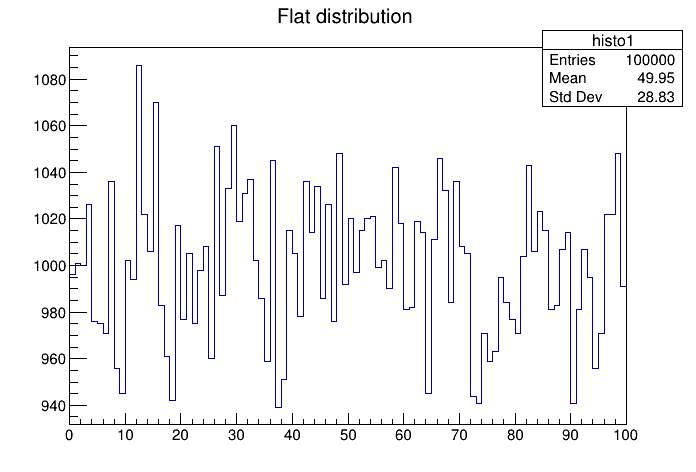

In [5]:
TCanvas *tempcanv = new TCanvas();
histo1->Draw();
tempcanv->Draw();

In [6]:
TH1D *histo2 = new TH1D("histo2","Gauss distribution", 100, 0, 100);
for (int i=0;i<100000;i++) {
    histo2->Fill(gRandom->Gaus(0,25));
}

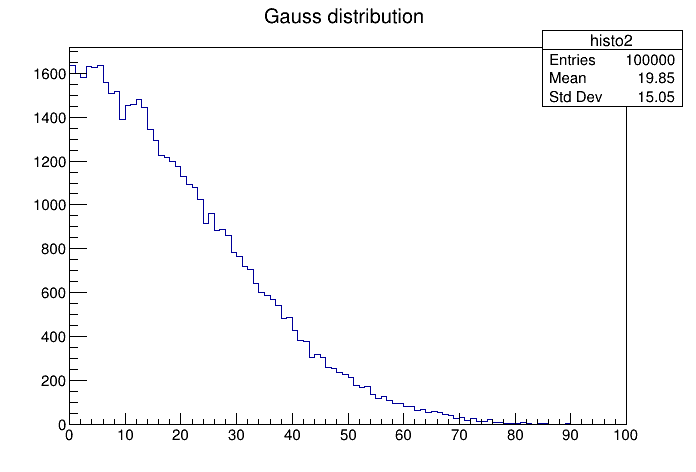

In [7]:
histo2->Draw();
tempcanv->Draw();

In [8]:
TH1D *histo3 = new TH1D("histo3","Gauss distribution2", 100, 0, 100);
for (int i=0;i<100000;i++) {
    histo3->Fill(gRandom->Gaus(100,25));
}

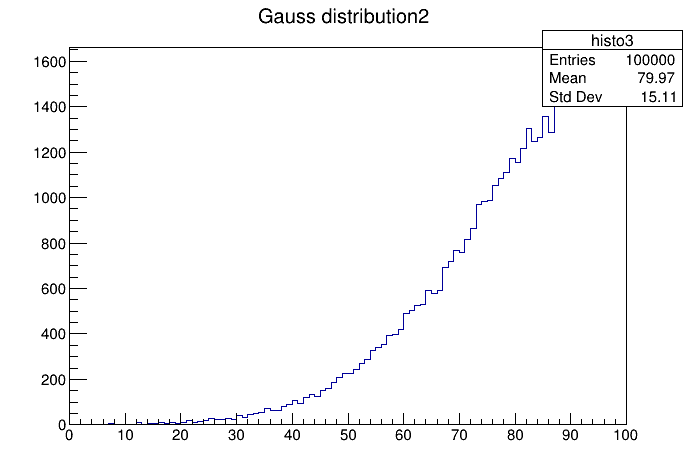

In [9]:
histo3->Draw();
tempcanv->Draw();

In [10]:
tempcanv->Dump()

==> Dumping object at: 0x00007f501c74a7e0, name=c1, class=TCanvas

fCatt                         ->7f501c74aa88      Canvas attributes
fCatt.fXBetween               2                   X distance between pads
fCatt.fYBetween               2                   Y distance between pads
fCatt.fTitleFromTop           1.2                 Y distance of Global Title from top
fCatt.fXdate                  0.2                 X position where to draw the date
fCatt.fYdate                  0.3                 X position where to draw the date
fCatt.fAdate                  1                   Alignment for the date
fDISPLAY                      $DISPLAY            Name of destination screen
fDISPLAY.fRep                 ->7f501c74aab0      ! String data
fDISPLAY.fRep.                ->7f501c74aab0      
fXsizeUser                    0                   User specified size of canvas along X in CM
fYsizeUser                    0                   User specified size of canvas along Y in CM
fXsizeReal

In [11]:
std::vector<TH1D *> Ejemplo;
Ejemplo.push_back(histo1);
Ejemplo.push_back(histo2);
Ejemplo.push_back(histo3);

In [12]:
Ejemplo.size()

(unsigned long) 3


In [13]:
TCanvas *canv = new TCanvas();
casee=Significance(histo2,Ejemplo);


In [14]:
casDrawe = casee.GetEffLessThan();

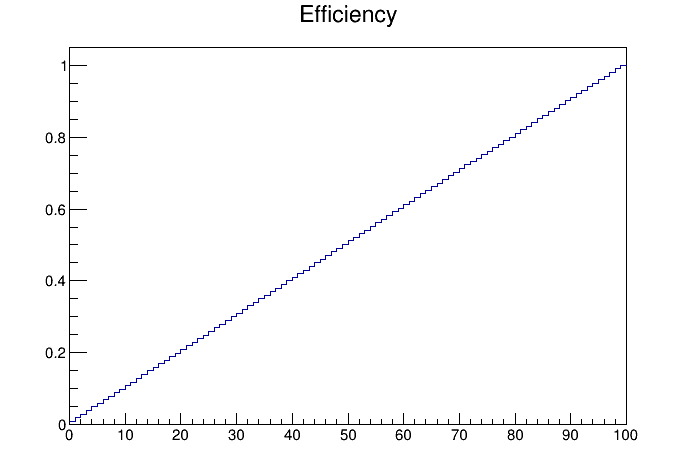

In [15]:
TCanvas *canv1 = new TCanvas();
casDrawe[0]->Draw();
canv1->Draw();

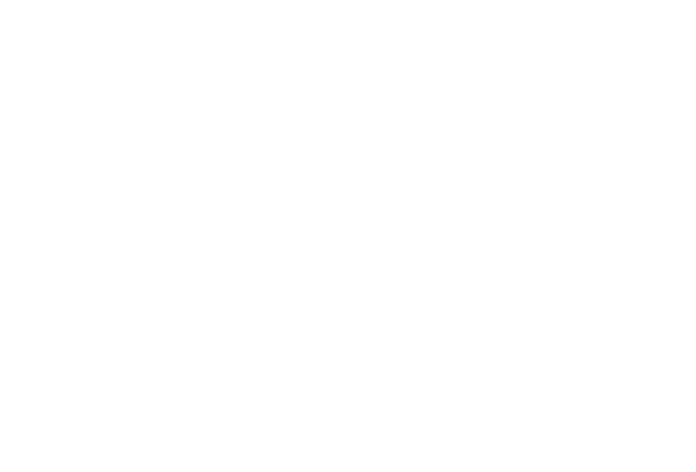

In [16]:
//TCanvas *canv = new TCanvas();
cas=Significance(histo2,histo2);
casDraw=cas.GetSignificance();
casDraw->Draw();
canv->Draw();

In [17]:
casDraw->GetMaximumBin()

(int) 1


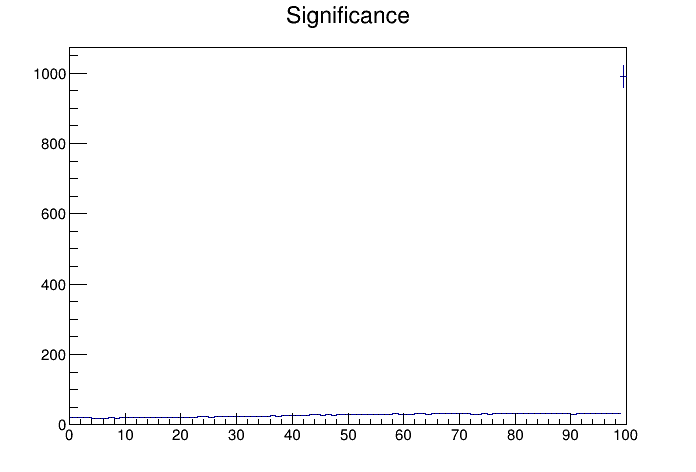

In [18]:
TCanvas *canv2 = new TCanvas();
cas2=Significance(histo1,histo2);
casDraw2=cas2.GetSignificance();
casDraw2->Draw();
canv2->Draw();

In [19]:
casDraw2->GetMaximum()

(double) 991.00000


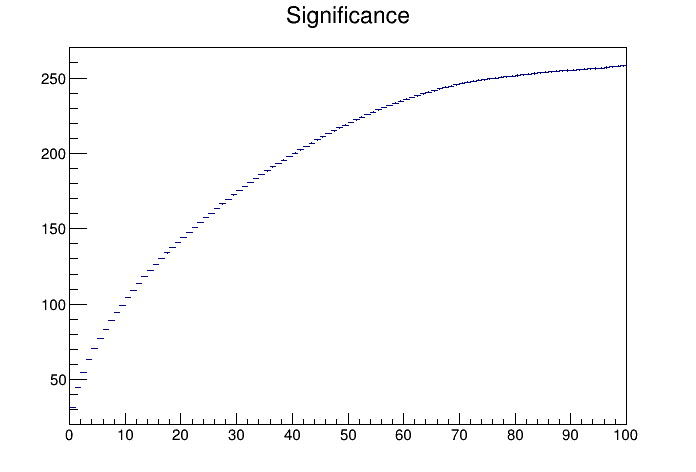

In [20]:
TCanvas *ca1 = new TCanvas();
casArr=Significance(histo1,histo3);
casDrawArr=casArr.GetSigLessThan();
casDrawArr->Draw();
ca1->Draw();

In [21]:
casDrawArr->GetMaximumBin()

(int) 100


In [22]:
casDrawArr->GetBinContent(casDrawArr->GetBinContent(2))

(double) 206.82386


In [23]:
casDrawArr->SetNameTitle("Camilo", "Andres")

In [24]:
gStyle->SetOptStat(0);

In [25]:
//casDrawArr->Dump();
TLegend * leg = new TLegend(0.1,0.7,0.3,.09);

In [26]:
leg->SetFillColor(3);
leg->AddEntry("casDrawArr","Nombre");
leg->Draw();

In [27]:
TPave * leg2 = new TPave(0.1,0.7,0.3,.09);

In [28]:
leg2->Draw();

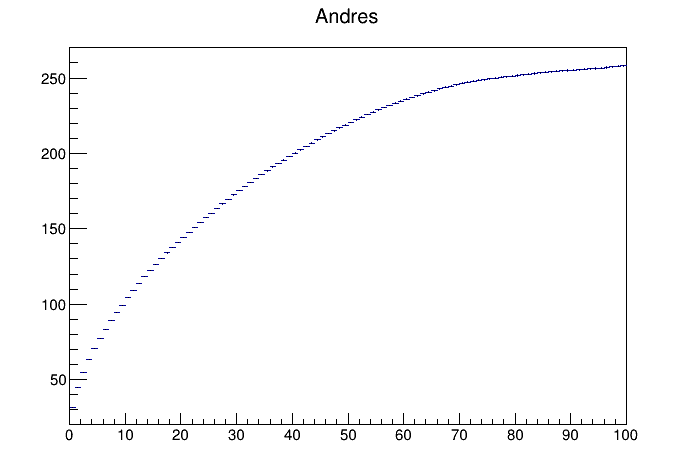

In [29]:
casDrawArr->Draw();
ca1->Draw("same");